# import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from scipy.stats import iqr
from functools import partial, reduce
from sqlalchemy import create_engine
import datetime
import warnings
import patsy
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn import metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf
from itertools import zip_longest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge 
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold
import seaborn as sb

# Read the data

In [2]:
df= pd.read_excel (r'Houses.xlsx')

In [3]:
df

,Price,Size,n_rooms,n_bathroom,Districts
0,"750,000 ريال",240 م²,7,5,Aldar-Albaida
1,"6,500,000 ريال",1237 م²,7,5,Alhamra
2,"1,650,000 ريال",375 م²,5,5,street
3,"6,000,000 ريال",625 م²,5,5,Almalga
4,"1,100,000 ريال",325 م²,5,5,Akath
...,...,...,...,...,...
21973,"1,400,000 ريال",510 م²,5,5,Alrawdah
21974,"2,000,000 ريال",623 م²,7,4,Alrawdah
21975,"1,110,000 ريال",330 م²,5,5,NaN
21976,"800,000 ريال",200 م²,1,1,Aljaradeh


# Split the data into : Train set and Test set

In [4]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [5]:
df = train_set.copy()

# Data Cleaning (Train set )

In [6]:
df.dropna(subset=[ 'Districts'], inplace=True)
df['Districts']=df['Districts'].str.strip()
df.drop(df[df['Districts'] == 'street' ].index, inplace = True)
df.drop(df[df['Districts'] == 'city' ].index, inplace = True)
df['Price'] = df['Price'].str.replace('ريال', '')
df['Size'] = df['Size'].str.replace('م²', '')
df["Price"]=df.Price.str.replace(',', '')
df["Price"] = df.Price.astype(float)
df["Size"] = df.Size.astype(float)
df.head()

,Price,Size,n_rooms,n_bathroom,Districts
5754,4000100.0,525.0,7,5,Al-Narjes
11379,8000000.0,1185.0,7,5,Alhamra
12981,1900000.0,355.0,3,3,Aleshah
21309,1800000.0,1050.0,7,5,Bader
6978,1400000.0,312.0,5,5,Alhazem


# Data Cleaning (Test set )

In [7]:

test_set.dropna(subset=[ 'Districts'], inplace=True)
test_set['Districts']=test_set['Districts'].str.strip()
test_set.drop(test_set[test_set['Districts'] == 'street' ].index, inplace = True)
test_set.drop(test_set[test_set['Districts'] == 'city' ].index, inplace = True)
test_set['Price'] = test_set['Price'].str.replace('ريال', '')
test_set['Size'] = test_set['Size'].str.replace('م²', '')
test_set["Price"]=test_set.Price.str.replace(',', '')
test_set["Price"] = test_set.Price.astype(float)
test_set["Size"] = test_set.Size.astype(float)
test_set.head()

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\admin\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

,Price,Size,n_rooms,n_bathroom,Districts
16666,830000.0,200.0,5,5,Aziziah
14182,1380000.0,300.0,5,5,Al-Remal
383,1120000.0,325.0,5,4,Akath
20478,2000000.0,623.0,7,4,Alrawdah
6216,2000000.0,623.0,7,4,Alrawdah


# EDA

# Houses price in different neighborhoods 

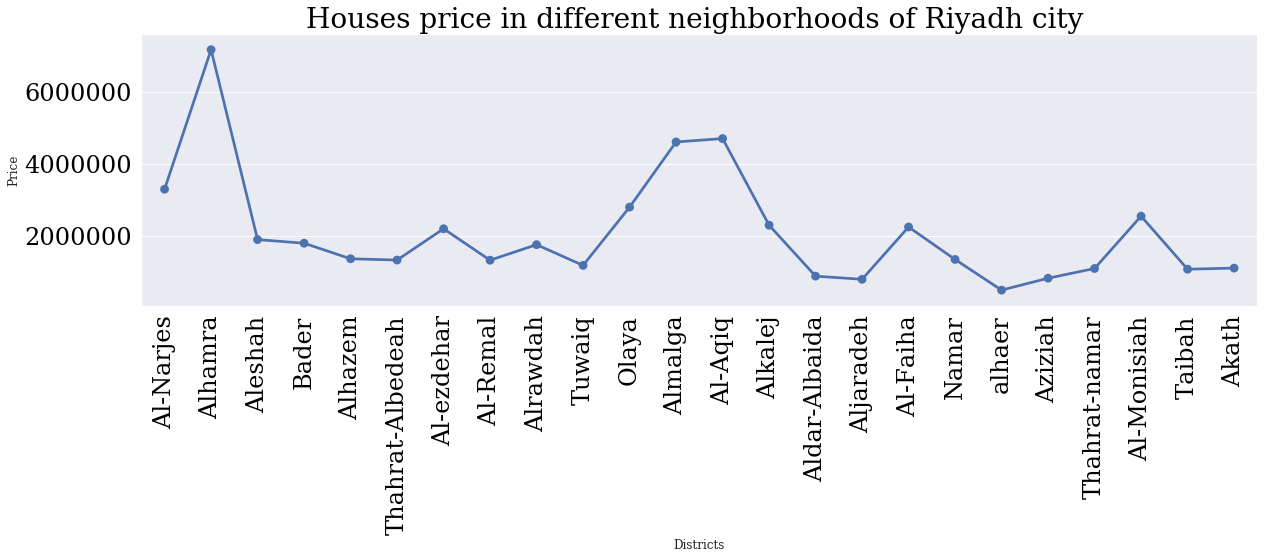

In [8]:
sns.set(rc={'figure.figsize':(20,5)})
plt.rc('xtick', labelsize=24,color ="#000000") 
plt.rc('ytick', labelsize=24,color ="#000000")
plt.rcParams["font.family"] = "serif"
plt.title('Houses price in different neighborhoods of Riyadh city ',fontsize = 28,color ="#000000")
g=sns.pointplot(x=df["Districts"] ,y=df["Price"], data=df,rotation=45);

g.set_xticklabels(g.get_xticklabels(), rotation=90)    
plt.show()

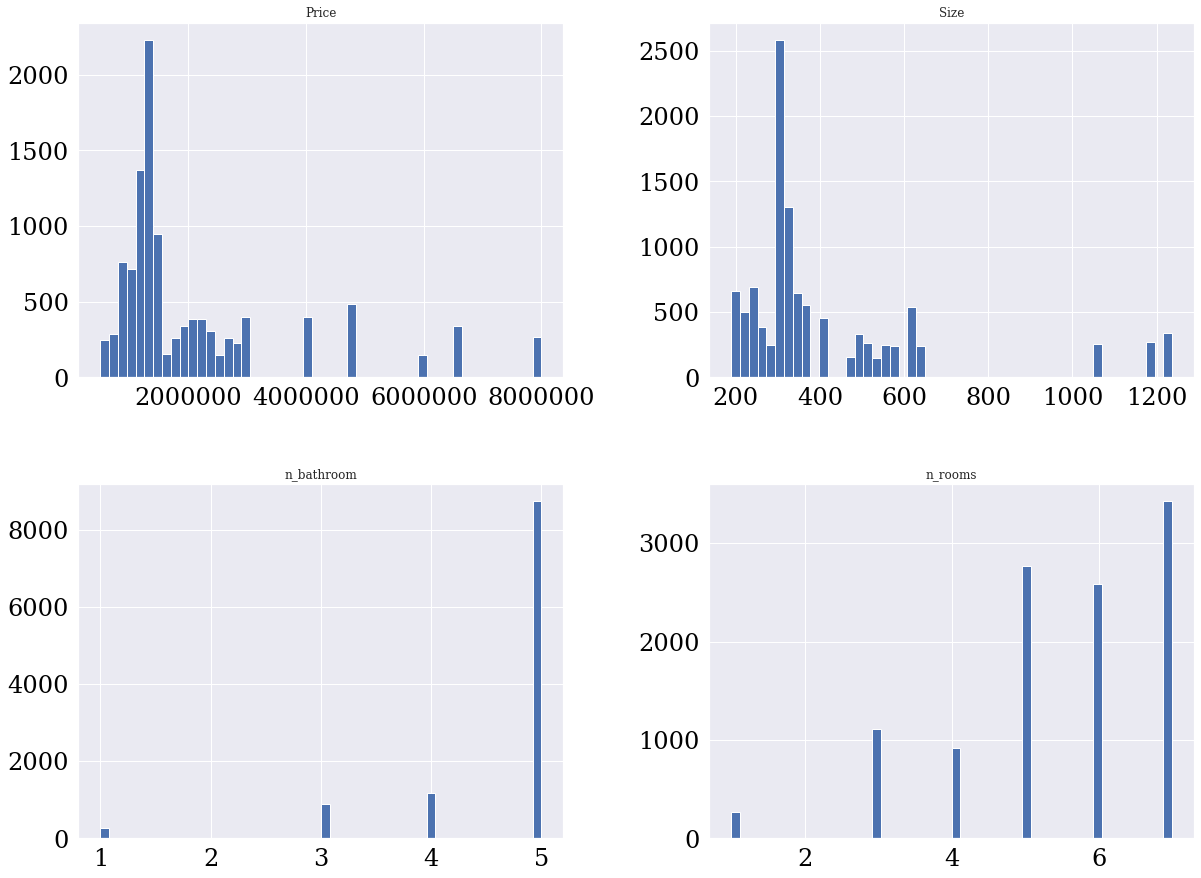

In [9]:

df.hist(bins=50, figsize=(20,15));

# Correlation

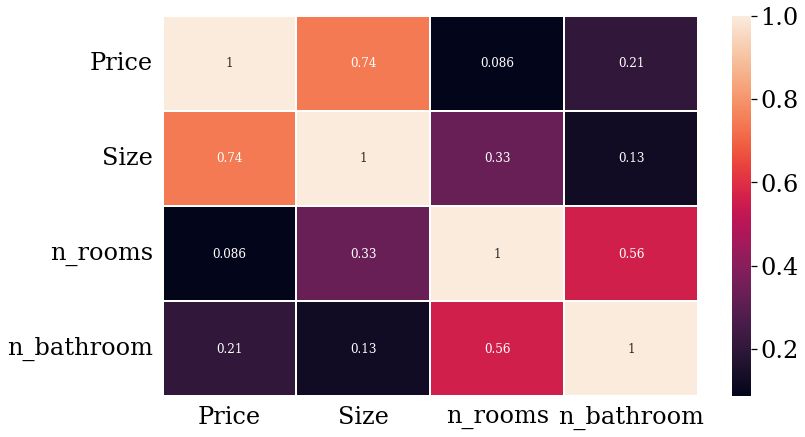

In [10]:
correlation = df.corr()
plt.figure(figsize=(12,7))
sns.heatmap(correlation, annot = True, linewidth = 1);

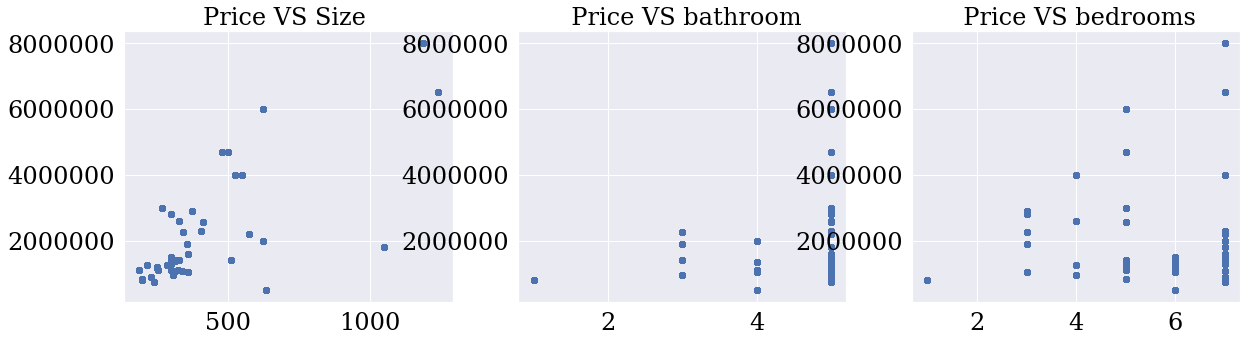

In [11]:
plt.subplot(1,3,1)
plt.scatter(df.Size,df.Price)
plt.title('Price VS Size ',fontsize = 24,color ="#000000")
plt.subplot(1,3,2)
plt.scatter(df.n_bathroom,df.Price)
plt.title('  Price VS bathroom ',fontsize = 24,color ="#000000")
plt.subplot(1,3,3)
plt.scatter(df.n_rooms,df.Price)
plt.title('  Price VS bedrooms ',fontsize = 24,color ="#000000");

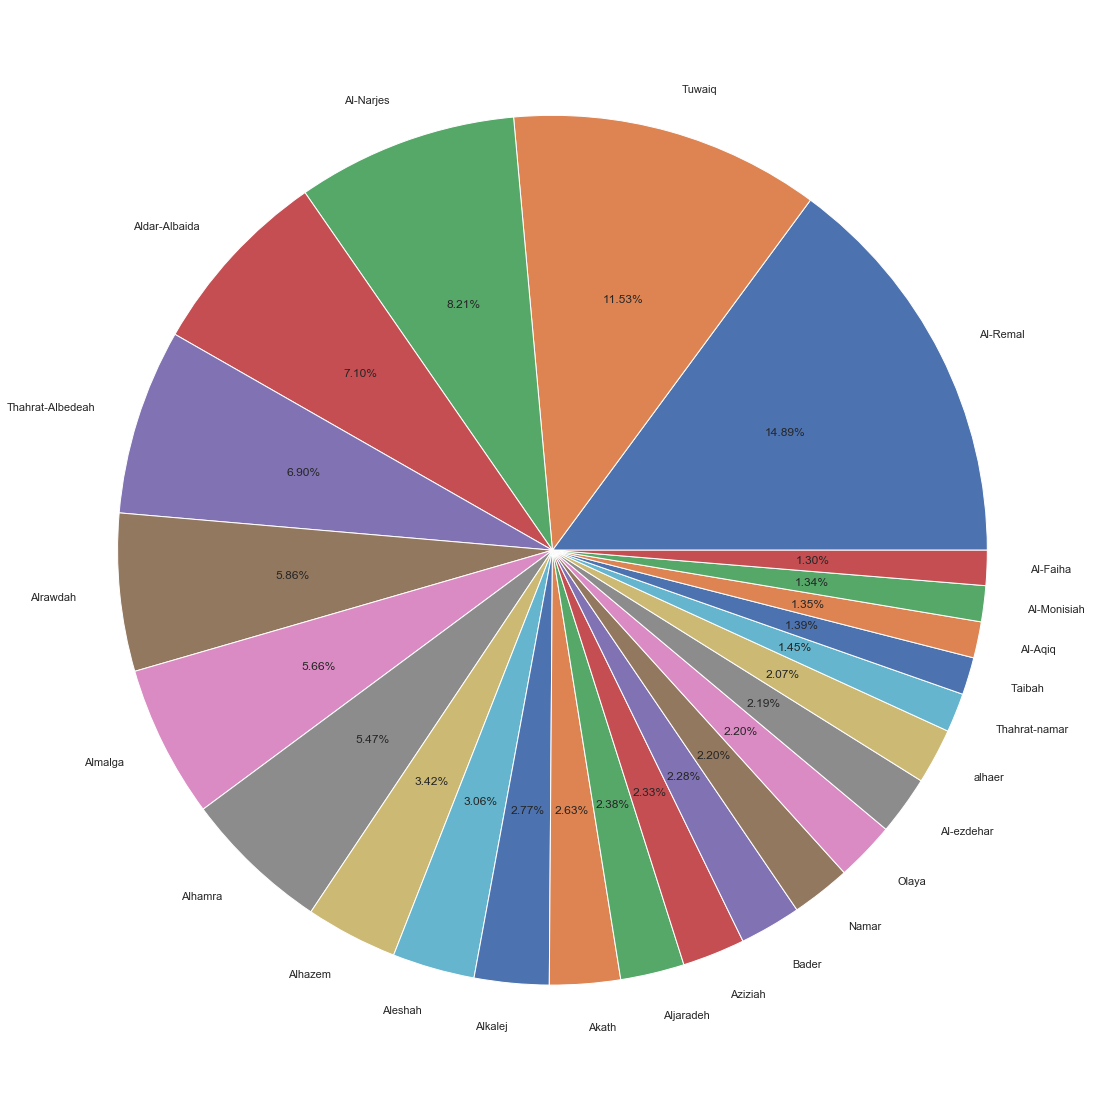

In [12]:

a=df["Districts"].value_counts()
sns.set(rc={'figure.figsize':(30,20)})
plt.pie(a, autopct='%1.2f%%',labels=[ "Al-Remal","Tuwaiq","Al-Narjes","Aldar-Albaida","Thahrat-Albedeah","Alrawdah","Almalga","Alhamra","Alhazem","Aleshah","Alkalej","Akath","Aljaradeh","Aziziah","Bader","Namar","Olaya",
"Al-ezdehar","alhaer","Thahrat-namar","Taibah","Al-Aqiq","Al-Monisiah","Al-Faiha"]);

# DataFrame without categorical values

In [13]:
selected_columns1 = df[["Price","Size","n_rooms","n_bathroom"]]
new_df = selected_columns1.copy()
new_df.head()

,Price,Size,n_rooms,n_bathroom
5754,4000100.0,525.0,7,5
11379,8000000.0,1185.0,7,5
12981,1900000.0,355.0,3,3
21309,1800000.0,1050.0,7,5
6978,1400000.0,312.0,5,5


In [14]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

X, y = new_df.drop('Price',axis=1), new_df['Price']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)
X, y = np.array(X), np.array(y)
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s, cv_lm_reg_r2s,poly_cv = [], [] ,[]

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)
    poly = LinearRegression()
    

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))

    
   
    
    poly = PolynomialFeatures(degree=2) 
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    lm.fit(X_train_poly, y_train)
    poly_cv.append(lm.score(X_val_poly, y_val))
    
    
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))
    
    

print('Linear regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_reg_r2s, '\n')
# mse = metrics.mean_squared_error(true, predicted)
print('poly scores: ', poly_cv, '\n')

print(f'Linear mean cv r^2: {np.mean(cv_lm_r2s):.6f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.6f} +- {np.std(cv_lm_reg_r2s):.3f}')
print(f'poly mean cv r^2: {np.mean(poly_cv):.6f} +- {np.std(poly_cv):.3f}')

Linear regression scores:  [0.6083180549097185, 0.6626479850502043, 0.6618293825470931, 0.6456200824930725, 0.6371528639559861]
Ridge scores:  [0.6083225766465847, 0.6626424185288191, 0.6618306340260574, 0.645620718910193, 0.6371523324559467] 

poly scores:  [0.6653644470603665, 0.7126442041312866, 0.7153014393724466, 0.6924103846414653, 0.7018440696467911] 

Linear mean cv r^2: 0.643114 +- 0.020
Ridge mean cv r^2: 0.643114 +- 0.020
poly mean cv r^2: 0.697513 +- 0.018


# Converting categorical values from Train set

In [15]:
df = pd.get_dummies(df, drop_first=True) 
df.head(3)

,Price,Size,n_rooms,n_bathroom,Districts_Al-Aqiq,Districts_Al-Faiha,Districts_Al-Monisiah,Districts_Al-Narjes,Districts_Al-Remal,Districts_Al-ezdehar,...,Districts_Alrawdah,Districts_Aziziah,Districts_Bader,Districts_Namar,Districts_Olaya,Districts_Taibah,Districts_Thahrat-Albedeah,Districts_Thahrat-namar,Districts_Tuwaiq,Districts_alhaer
5754,4000100.0,525.0,7,5,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
11379,8000000.0,1185.0,7,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12981,1900000.0,355.0,3,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
df.shape

(11073, 27)

# Converting categorical values from Test set

In [17]:
test_set = pd.get_dummies(test_set, drop_first=True) 
test_set.head(3)

,Price,Size,n_rooms,n_bathroom,Districts_Al-Aqiq,Districts_Al-Faiha,Districts_Al-Monisiah,Districts_Al-Narjes,Districts_Al-Remal,Districts_Al-ezdehar,...,Districts_Alrawdah,Districts_Aziziah,Districts_Bader,Districts_Namar,Districts_Olaya,Districts_Taibah,Districts_Thahrat-Albedeah,Districts_Thahrat-namar,Districts_Tuwaiq,Districts_alhaer
16666,830000.0,200.0,5,5,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
14182,1380000.0,300.0,5,5,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
383,1120000.0,325.0,5,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
test_set.shape

(2795, 27)

# Correlation after dummy

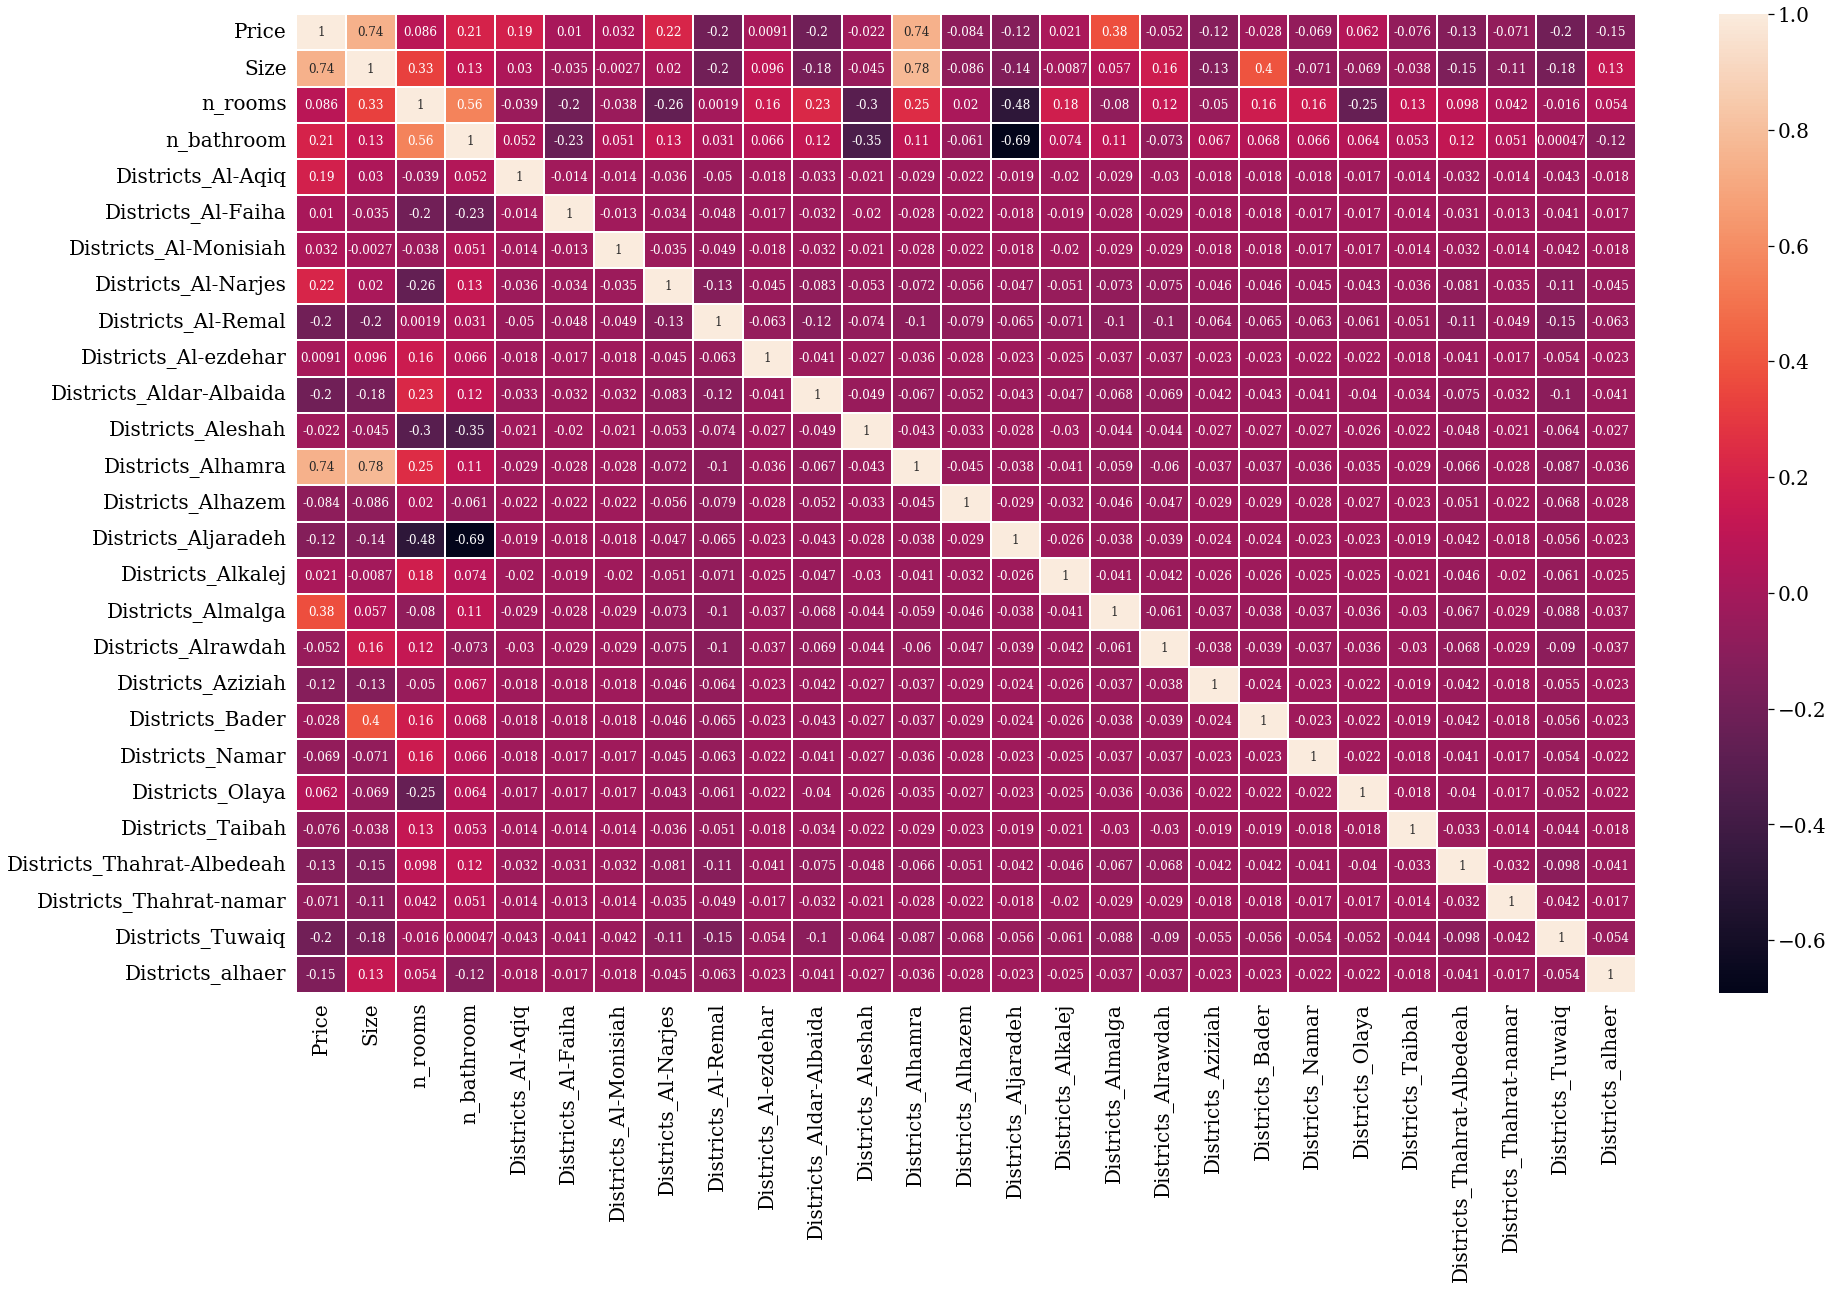

In [19]:
correlation = df.corr()
plt.figure(figsize=(30,18))
plt.rc('xtick', labelsize=20,color ="#000000") 
plt.rc('ytick', labelsize=20,color ="#000000")
plt.rcParams["font.family"] = "serif"
sns.heatmap(correlation, annot = True, linewidth = 1);

# Cross validation : Linear , Poly , Ridge

In [20]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

X, y = df.drop('Price',axis=1), df['Price']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)
X, y = np.array(X), np.array(y)
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s, cv_lm_reg_r2s,poly_cv = [], [] ,[]

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)
    poly = LinearRegression()
    

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))

    
   
    
    poly = PolynomialFeatures(degree=2) 
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    lm.fit(X_train_poly, y_train)
    poly_cv.append(lm.score(X_val_poly, y_val))
    
    
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))
    
    

print('Linear regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_reg_r2s, '\n')
# mse = metrics.mean_squared_error(true, predicted)
print('poly scores: ', poly_cv, '\n')

print(f'Linear mean cv r^2: {np.mean(cv_lm_r2s):.6f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.6f} +- {np.std(cv_lm_reg_r2s):.3f}')
print(f'poly mean cv r^2: {np.mean(poly_cv):.6f} +- {np.std(poly_cv):.3f}')

Linear regression scores:  [0.9778952260006121, 0.9773947201817123, 0.9772533759330192, 0.9774821677029732, 0.9768995185562968]
Ridge scores:  [0.9778926925413869, 0.9773995292562554, 0.97725586450558, 0.9774838613376433, 0.9768909034436053] 

poly scores:  [0.9993052910602944, 0.9993240840639037, 0.9992033374907544, 0.9992393217035351, 0.9992402038603585] 

Linear mean cv r^2: 0.977385 +- 0.000
Ridge mean cv r^2: 0.977385 +- 0.000
poly mean cv r^2: 0.999262 +- 0.000


# Choosing the best model 

In [22]:
X_test, y_test = test_set.drop('Price',axis=1), test_set['Price']
lm.fit(X, y)
print(f'Linear Regression test R^2: {lm.score(X_test, y_test):.3f}')

Linear Regression test R^2: 0.978


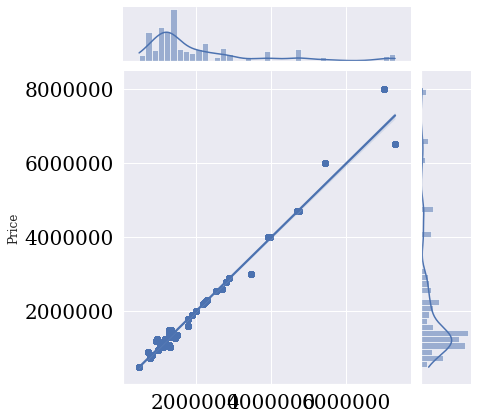

In [23]:
reg = LinearRegression().fit(X, y)
y_predicted = reg.predict(X_test)
#Plot Our Actual and Predicted Values
sns.jointplot(x=y_predicted,y=y_test,kind='reg')

In [24]:
from sklearn import metrics

def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

results_df = pd.DataFrame(data=[[ *evaluate(y_test, y_predicted)]],columns=[ 'MAE', 'MSE', 'RMSE', 'R2 Square'])
results_df


,MAE,MSE,RMSE,R2 Square
0,118017.869849,5.161332e+10,227185.657678,0.97808


In [25]:
print(reg.intercept_)
print(reg.coef_)

-1460096.2148001334
[    5514.50394747    64383.28382696   101744.14536905  2682497.1740351
  1320239.07323032   907483.44246303  1581892.75000587   303360.3684679
  -470147.26862851   -25533.42509144   904065.02586054   969432.84588958
   342552.06496963   991067.99611038   567318.40244144  2614178.97455817
  -813003.84930071   356558.27932622 -3489536.64367635   196341.31692532
  1903874.45223335  -294238.84097373   344079.80076095   622834.5389216
   205039.35497548 -2329375.57233309]


In [26]:
df.shape

(11073, 27)

# Try Lasso and ElasticNet model

In [272]:
model = Lasso(alpha=0.1, 
              precompute=True,  
              positive=True, 
              selection='random',
              random_state=42)
model.fit(X_train, y_train)


train_pred = model.predict(X_train)
r2_square_Train = metrics.r2_score(y_train, train_pred)


print(f'Train set evaluation:{r2_square_Train}')



Train set evaluation:0.8931568405641584


In [273]:
model = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=42)
model.fit(X_train, y_train)


train_pred = model.predict(X_train)

r2_square_Train = metrics.r2_score(y_train, train_pred)


print(f'Train set evaluation:{r2_square_Train}')


Train set evaluation:0.9264798241758878


# Try apply log for Price

In [274]:
df2=df
df2['log_price']=np.log(df2.Price)

from sklearn import metrics
from sklearn.model_selection import cross_val_score

X, y = df2.drop('log_price',axis=1), df2['log_price']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)
X, y = np.array(X), np.array(y)
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s, cv_lm_reg_r2s,poly_cv = [], [] ,[]

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)
    poly = LinearRegression()
    

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))

    
   
    
    poly = PolynomialFeatures(degree=2) 
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    lm.fit(X_train_poly, y_train)
    poly_cv.append(lm.score(X_val_poly, y_val))
    
    
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))
    
    

print('Linear regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_reg_r2s, '\n')
print('poly scores: ', poly_cv, '\n')
print(f'Linear mean cv r^2: {np.mean(cv_lm_r2s):.6f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.6f} +- {np.std(cv_lm_reg_r2s):.3f}')
print(f'poly mean cv r^2: {np.mean(poly_cv):.6f} +- {np.std(poly_cv):.3f}')

Linear regression scores:  [0.992724021899548, 0.9934925503418709, 0.9926149826334211, 0.9930099485034286, 0.9932083132998434]
Ridge scores:  [0.9927209923694266, 0.9934918702223516, 0.9926179041008919, 0.9930088464949991, 0.993204445123606] 

poly scores:  [0.9999996291301144, 0.9999649277470389, 0.9999635601173094, 0.9999833101535014, 0.9999700900218594] 

Linear mean cv r^2: 0.993010 +- 0.000
Ridge mean cv r^2: 0.993009 +- 0.000
poly mean cv r^2: 0.999976 +- 0.000
